## DM-14762: Rerun complete HiTS 2015 data processing on the VC

This notebook makes some plots to investigate the results of running ap_pipe with new and improved templates.

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
import sqlite3
from astropy.time import Time
from collections import Counter

from lsst.daf.base import DateTime
import lsst.afw.image as afwImage
import lsst.daf.persistence as dafPersist
import lsst.geom

In [26]:
repo = '/project/mrawls/hits2015/rerun/newtemplate1'
butler = dafPersist.Butler(repo)

## Read the association database into pandas

In [27]:
sqliteFile = 'association.db'
connection = sqlite3.connect(os.path.join(repo, sqliteFile))

tables = {'obj': 'dia_objects', 'src': 'dia_sources', 'ccd': 'CcdVisit'}

objTable = pd.read_sql_query('select * from {0};'.format(tables['obj']), connection)
srcTable = pd.read_sql_query('select * from {0};'.format(tables['src']), connection)
ccdTable = pd.read_sql_query('select * from {0};'.format(tables['ccd']), connection)

connection.close()

## Make two "subsets" of sources on the sky, with a declination cut

This is legit because we know how the dataset is positioned on the sky a priori

In [28]:
dec_set1 = (objTable['coord_dec'] > -2)
dec_set2 = ~dec_set1

## Histogram of how many sources there are per object

<IPython.core.display.Javascript object>


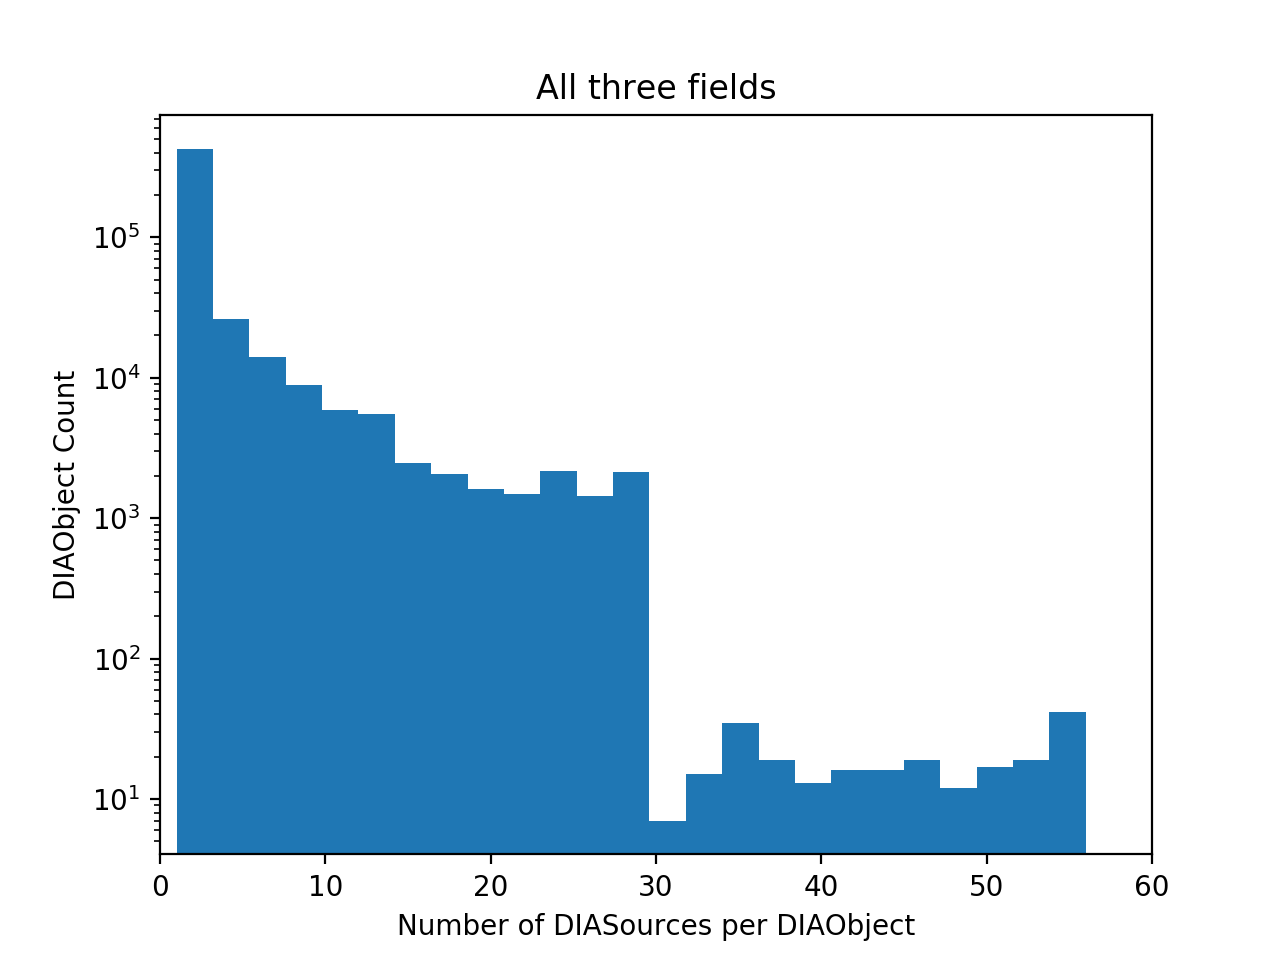

(0, 60)

In [29]:
count = objTable['nDiaSources'].values
plt.figure()
plt.hist(count, bins=25)
plt.yscale('log')
plt.xlabel('Number of DIASources per DIAObject')
plt.ylabel('DIAObject Count')
plt.title('All three fields')
plt.gca().set_xlim([0, 60])

<IPython.core.display.Javascript object>


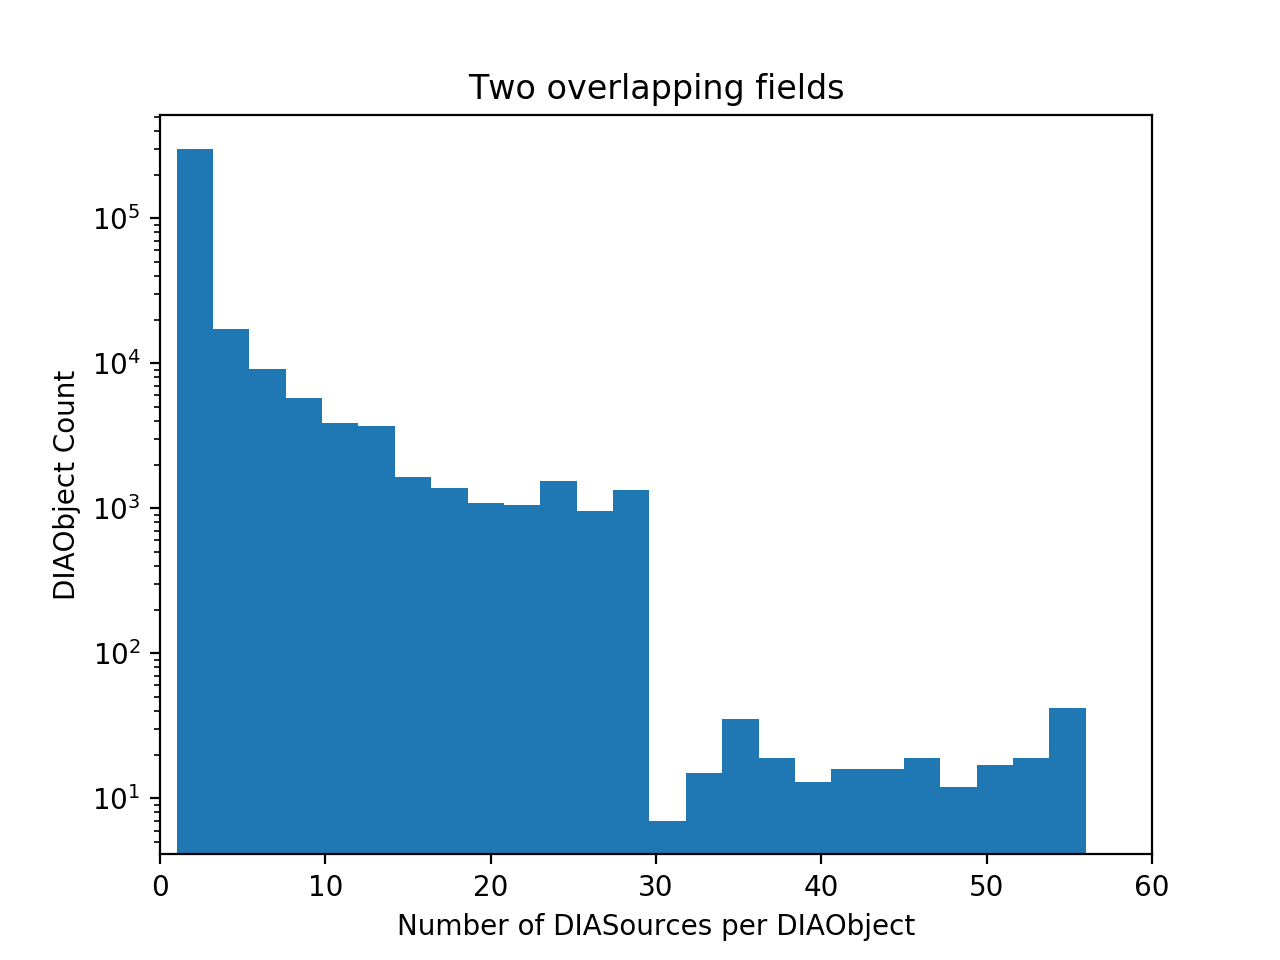

(0, 60)

In [30]:
count = objTable.loc[dec_set2, 'nDiaSources'].values
plt.figure()
plt.hist(count, bins=25)
plt.yscale('log')
plt.xlabel('Number of DIASources per DIAObject')
plt.ylabel('DIAObject Count')
plt.title('Two overlapping fields')
plt.gca().set_xlim([0, 60])

<IPython.core.display.Javascript object>


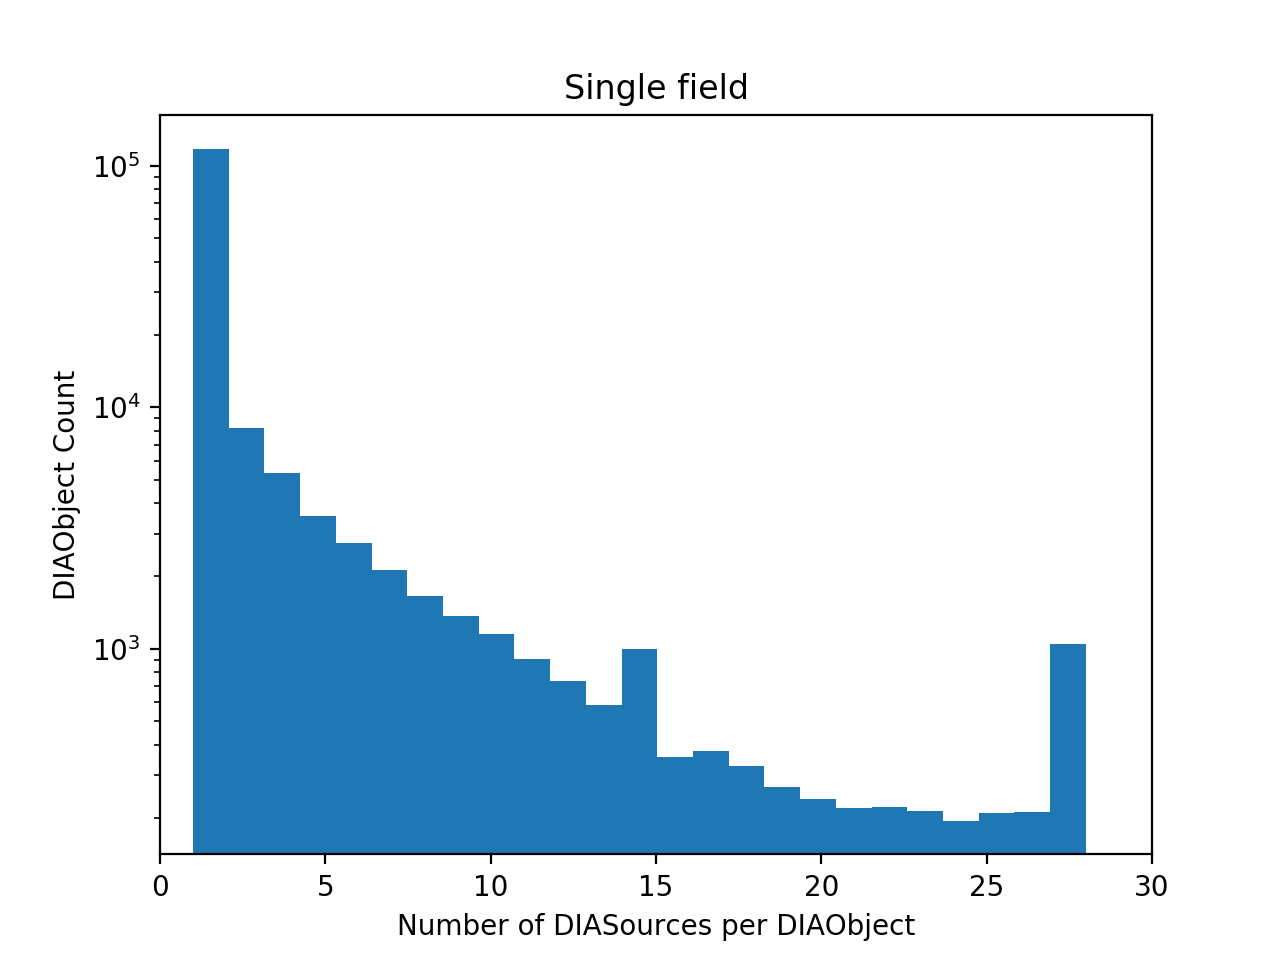

(0, 30)

In [31]:
count = objTable.loc[dec_set1, 'nDiaSources'].values
plt.figure()
plt.hist(count, bins=25)
plt.yscale('log')
plt.xlabel('Number of DIASources per DIAObject')
plt.ylabel('DIAObject Count')
plt.title('Single field')
plt.gca().set_xlim([0, 30])

## Visualizing the objects on the sky, colored and sized by number of sources

<IPython.core.display.Javascript object>


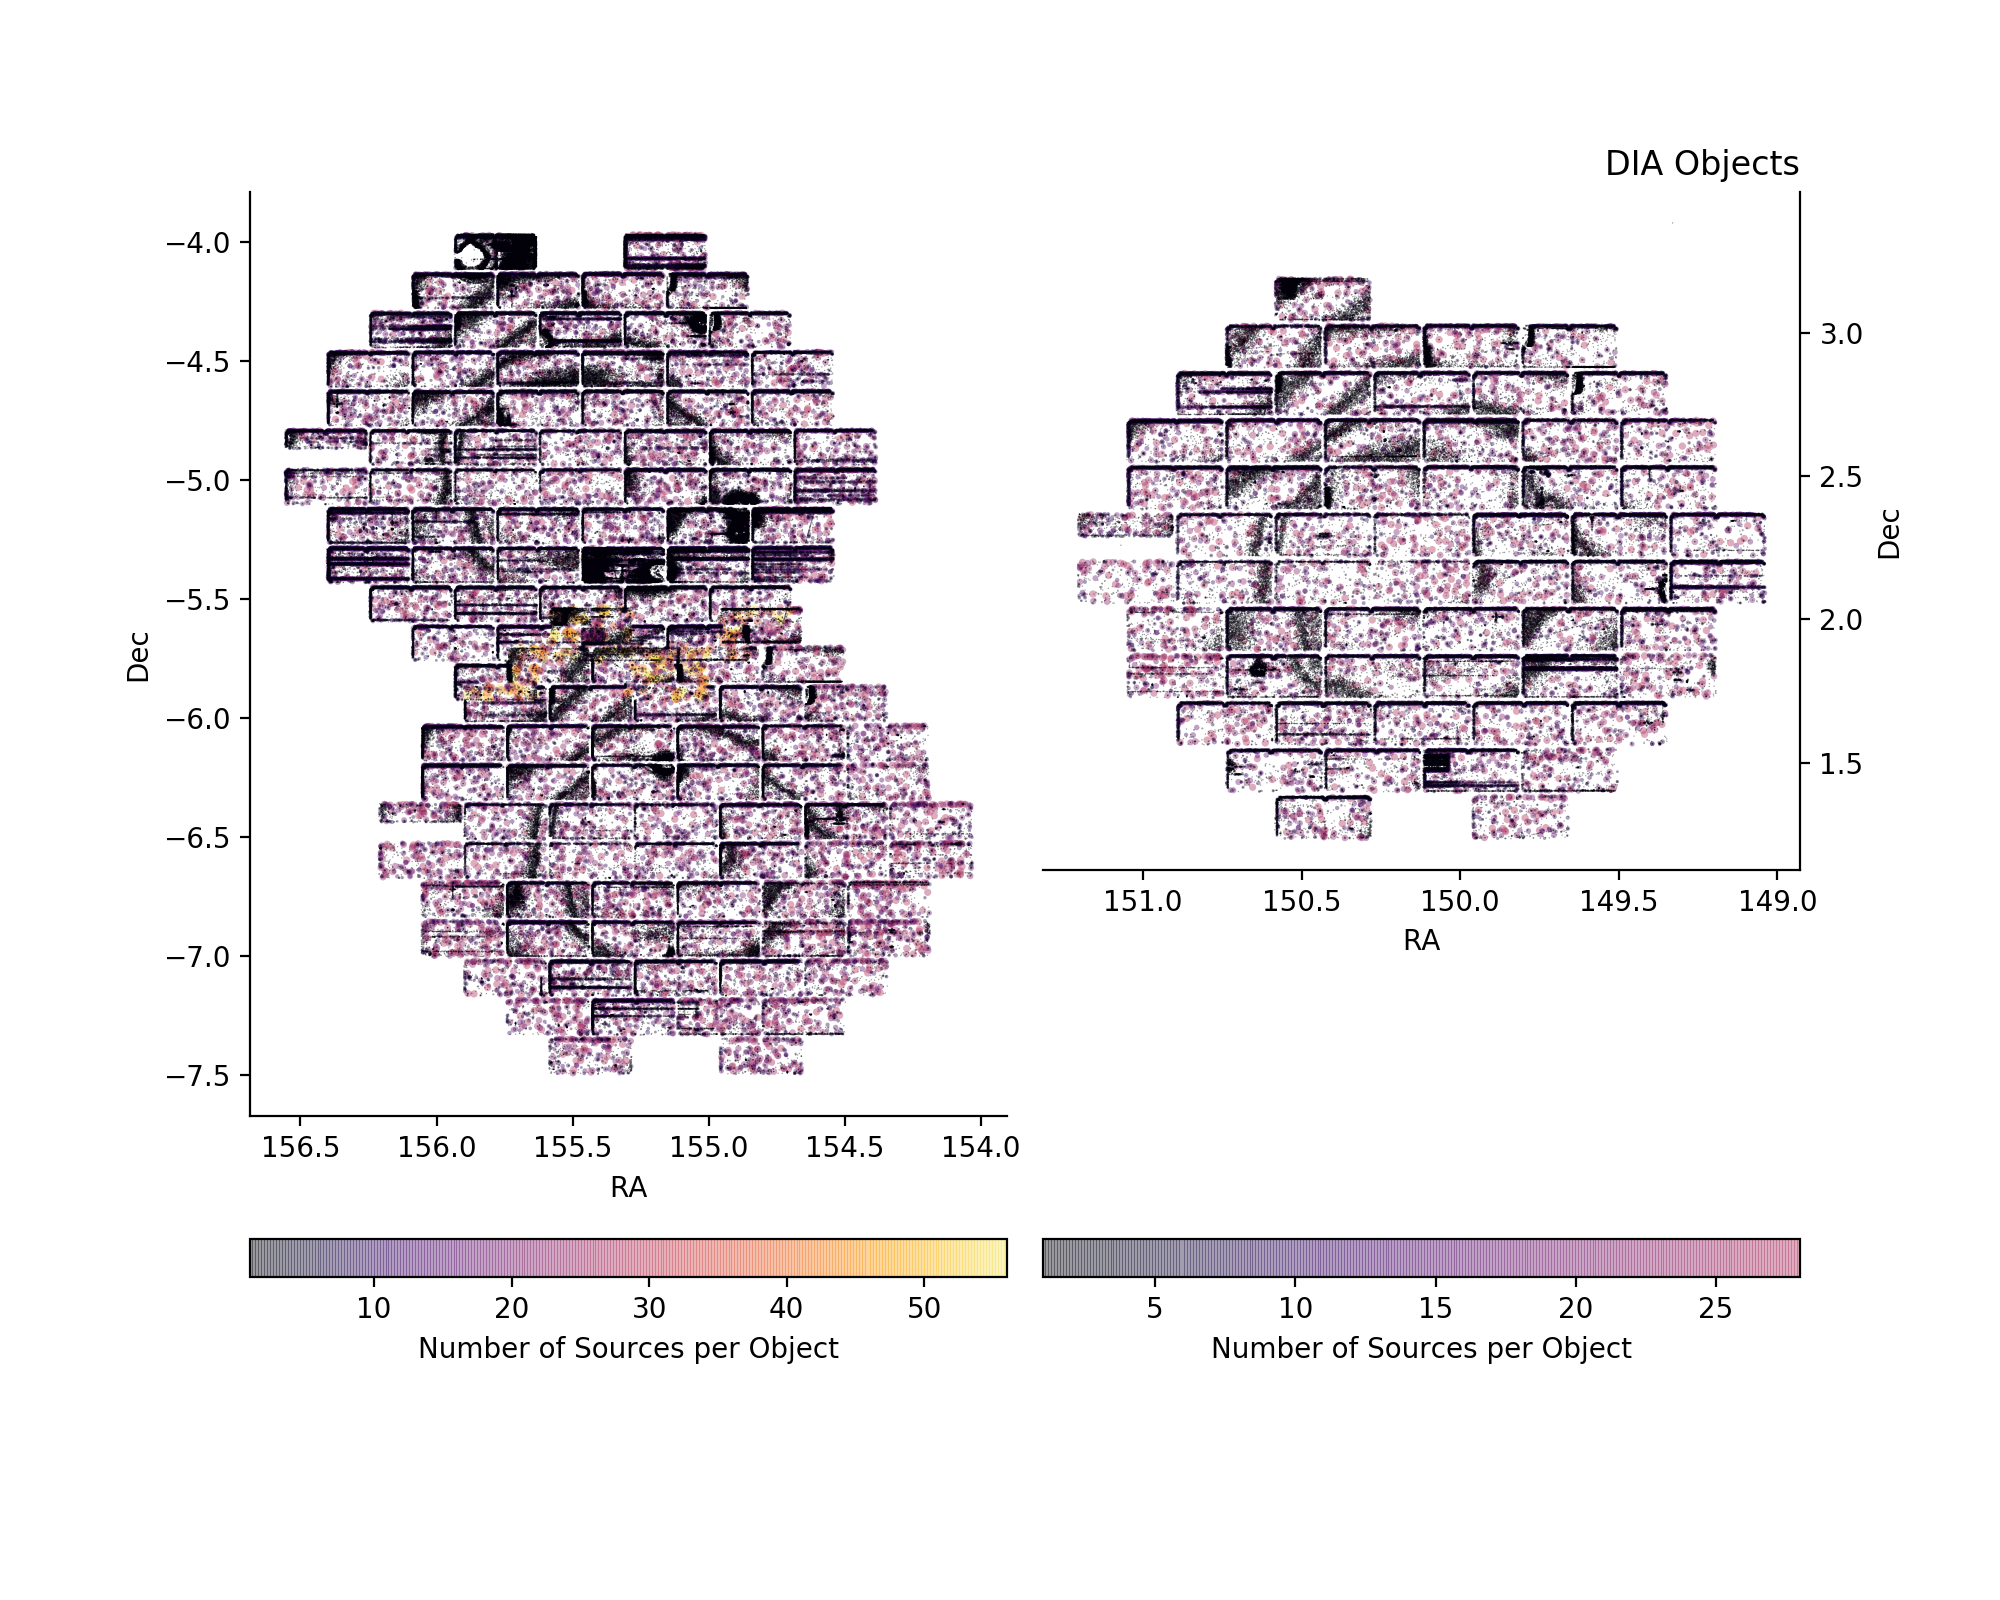

In [32]:
fig = plt.figure(facecolor='white', figsize=(10,8))
plt.subplots_adjust(wspace=0.1, hspace=0)

# Panel 1: one HiTS field
ax1 = plt.subplot2grid((4,4), (0,2), rowspan=4, colspan=2)
ax1.set_facecolor('white')
plot1 = ax1.scatter(objTable.loc[dec_set1, 'coord_ra'], objTable.loc[dec_set1, 'coord_dec'], marker='.',
                  lw=0, s=objTable.loc[dec_set1, 'nDiaSources'], c=objTable.loc[dec_set1, 'nDiaSources'],
                  alpha=0.4, cmap='inferno')
plt.title('DIA Objects', loc='right')
plt.xlabel('RA')
plt.ylabel('Dec')
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
ax1.invert_xaxis()  # RA should increase to the left
cb = fig.colorbar(plot1, orientation='horizontal', pad=0.3)
cb.set_label('Number of Sources per Object')
cb.set_clim(0, 60)

# Panel 2: two (overlapping) HiTS fields
ax2 = plt.subplot2grid((4,4), (0,0), rowspan=4, colspan=2)
ax2.set_facecolor('white')
plot2 = ax2.scatter(objTable.loc[dec_set2, 'coord_ra'], objTable.loc[dec_set2, 'coord_dec'], marker='.',
                  lw=0, s=objTable.loc[dec_set2, 'nDiaSources'], c=objTable.loc[dec_set2, 'nDiaSources'],
                  alpha=0.4, cmap='inferno')
plt.xlabel('RA')
plt.ylabel('Dec')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.invert_xaxis()
cb2 = fig.colorbar(plot2, orientation='horizontal', pad=0.1)
cb2.set_label('Number of Sources per Object')
cb2.set_clim(0, 60)

## Zoom on the overlap region of the two fields

<IPython.core.display.Javascript object>


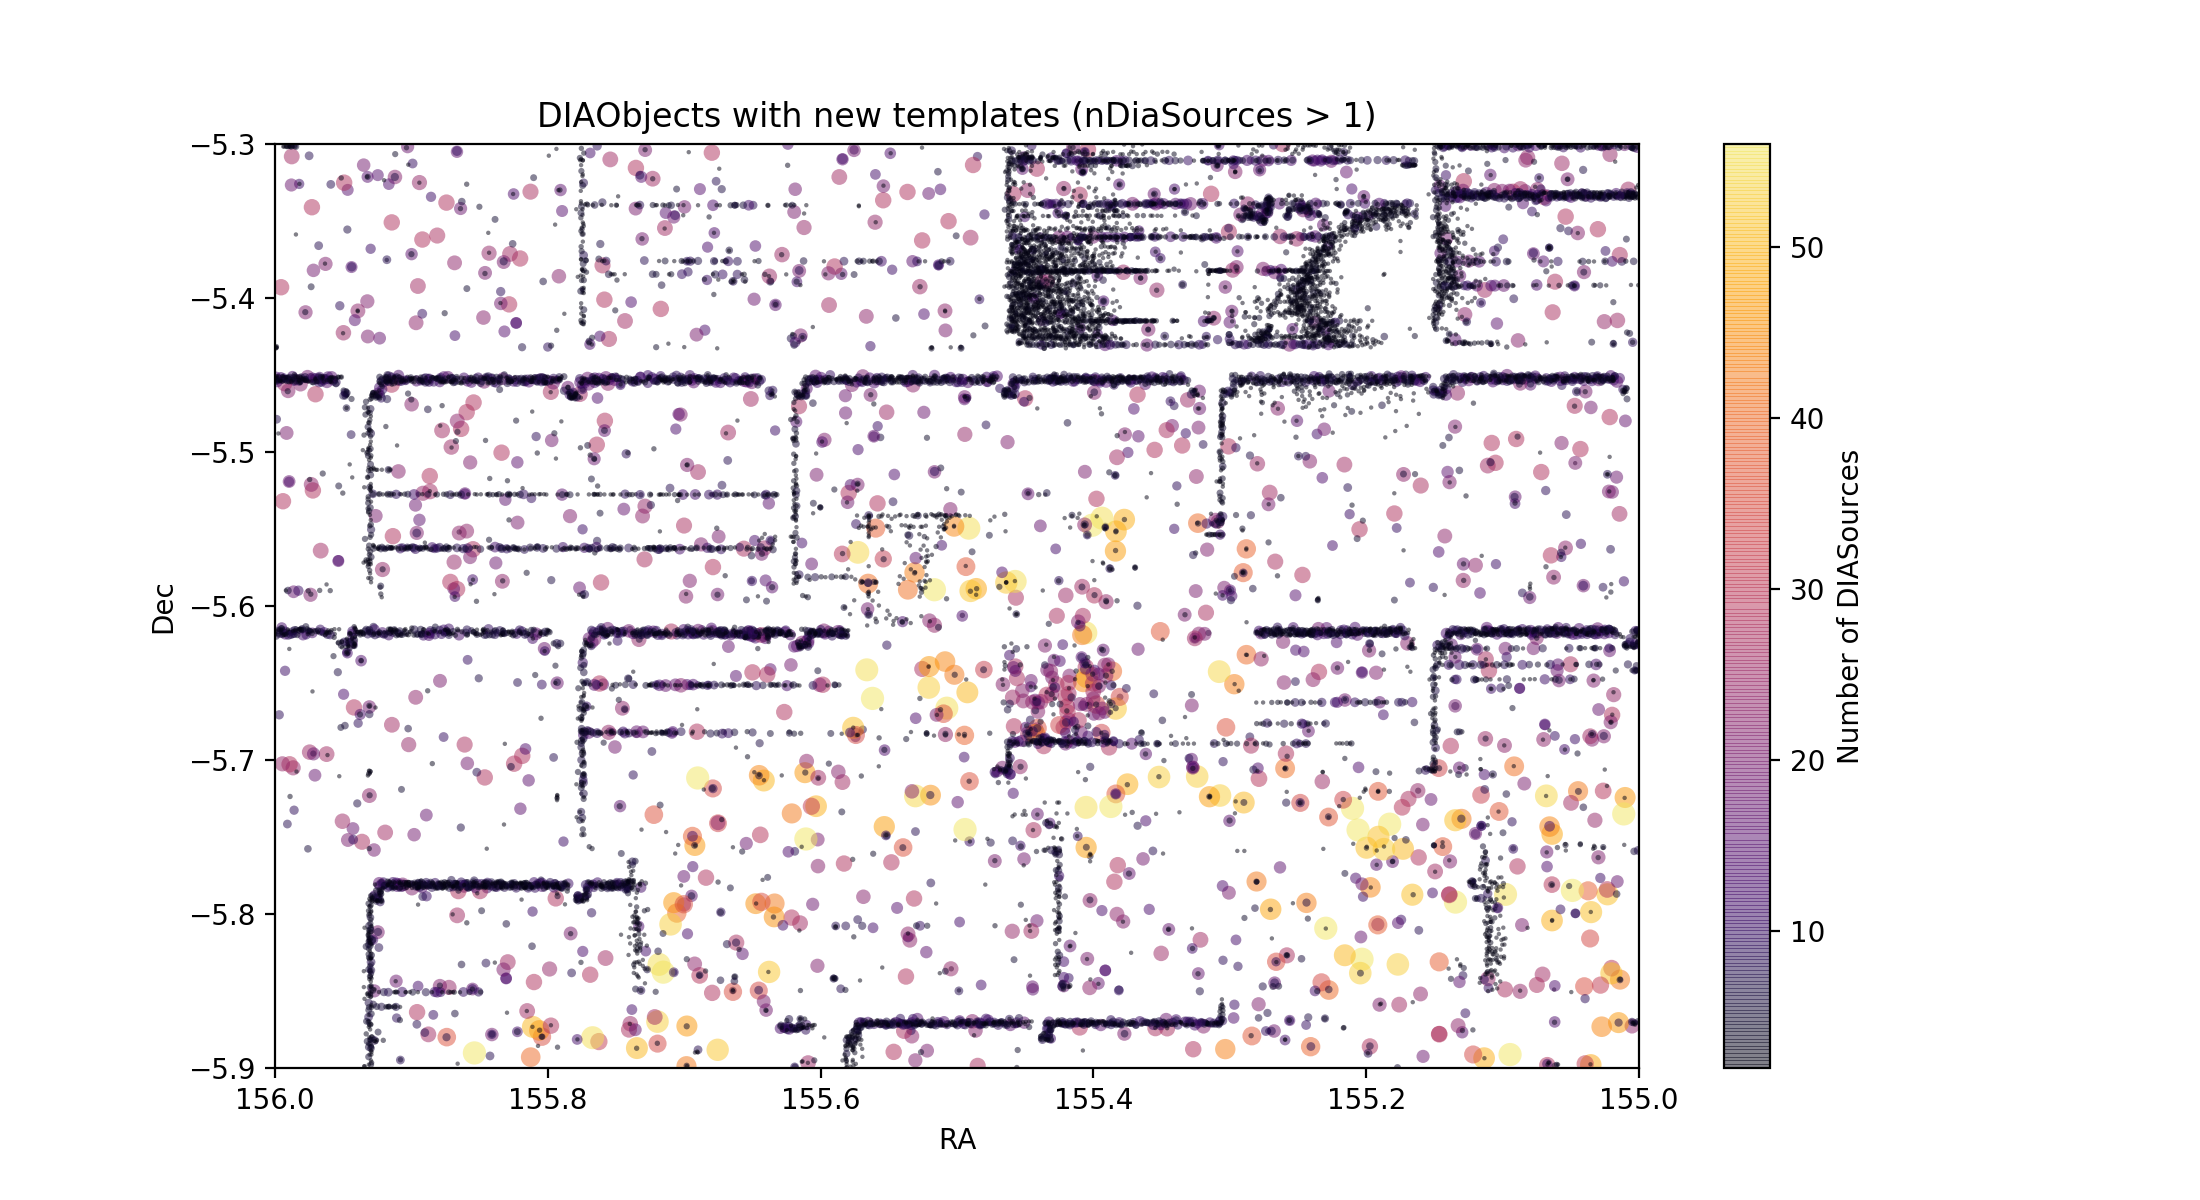

(-5.9, -5.3)

In [64]:
mini_region = ((objTable['coord_dec'] < -5.3) & (objTable['coord_dec'] > -5.9) & 
               (objTable['coord_ra'] > 155.0) & (objTable['coord_ra'] < 156.0) &
               (objTable['nDiaSources'] > 1))

fig = plt.figure(facecolor='white', figsize=(11,6))
ax1 = fig.add_subplot(111)
cb1 = ax1.scatter(objTable.loc[mini_region, 'coord_ra'], objTable.loc[mini_region, 'coord_dec'], marker='.',
                  lw=0, s=objTable.loc[mini_region, 'nDiaSources']*5, c=objTable.loc[mini_region, 'nDiaSources'],
                  alpha=0.5, cmap=plt.cm.get_cmap('inferno'))
cbplot = plt.colorbar(cb1, ax=ax1)
cbplot.set_label('Number of DIASources')
cbplot.set_clim(0, 60)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('DIAObjects with new templates (nDiaSources > 1)')
plt.xlim([156, 155.0])
plt.ylim([-5.9, -5.3])

In [11]:
len(objTable.loc[mini_region, 'id'])

7644

## Revisiting the CI region

In [34]:
ci_visits = [41137156, 41137160, 41142005, 41142010, 41980205, 41980210]

ci_objects = []
#ci_sources = []
for ci_visit in ci_visits:
    ci_objects.extend(srcTable.loc[srcTable['ccdVisitId'] == ci_visit, 'diaObjectId'].values)
    #ci_sources.extend(srcTable.loc[srcTable['ccdVisitId'] == ci_visit, 'id'].values)
    
objTable.set_index('id', inplace=True)  # ONLY DO THIS ONCE
srcTable.set_index('id', inplace=True)  # ONLY DO THIS ONCE

In [35]:
all_src_count = objTable.loc[ci_objects, 'nDiaSources']
ci_src_count = list(Counter(ci_objects).values())

colors = []
for count in ci_src_count:
    if count == 1:
        colors.append('0.5')
    elif count == 2:
        colors.append('C0')
    elif count == 3:
        colors.append('C1')
    else:
        colors.append('C2')
        print(count)

<IPython.core.display.Javascript object>


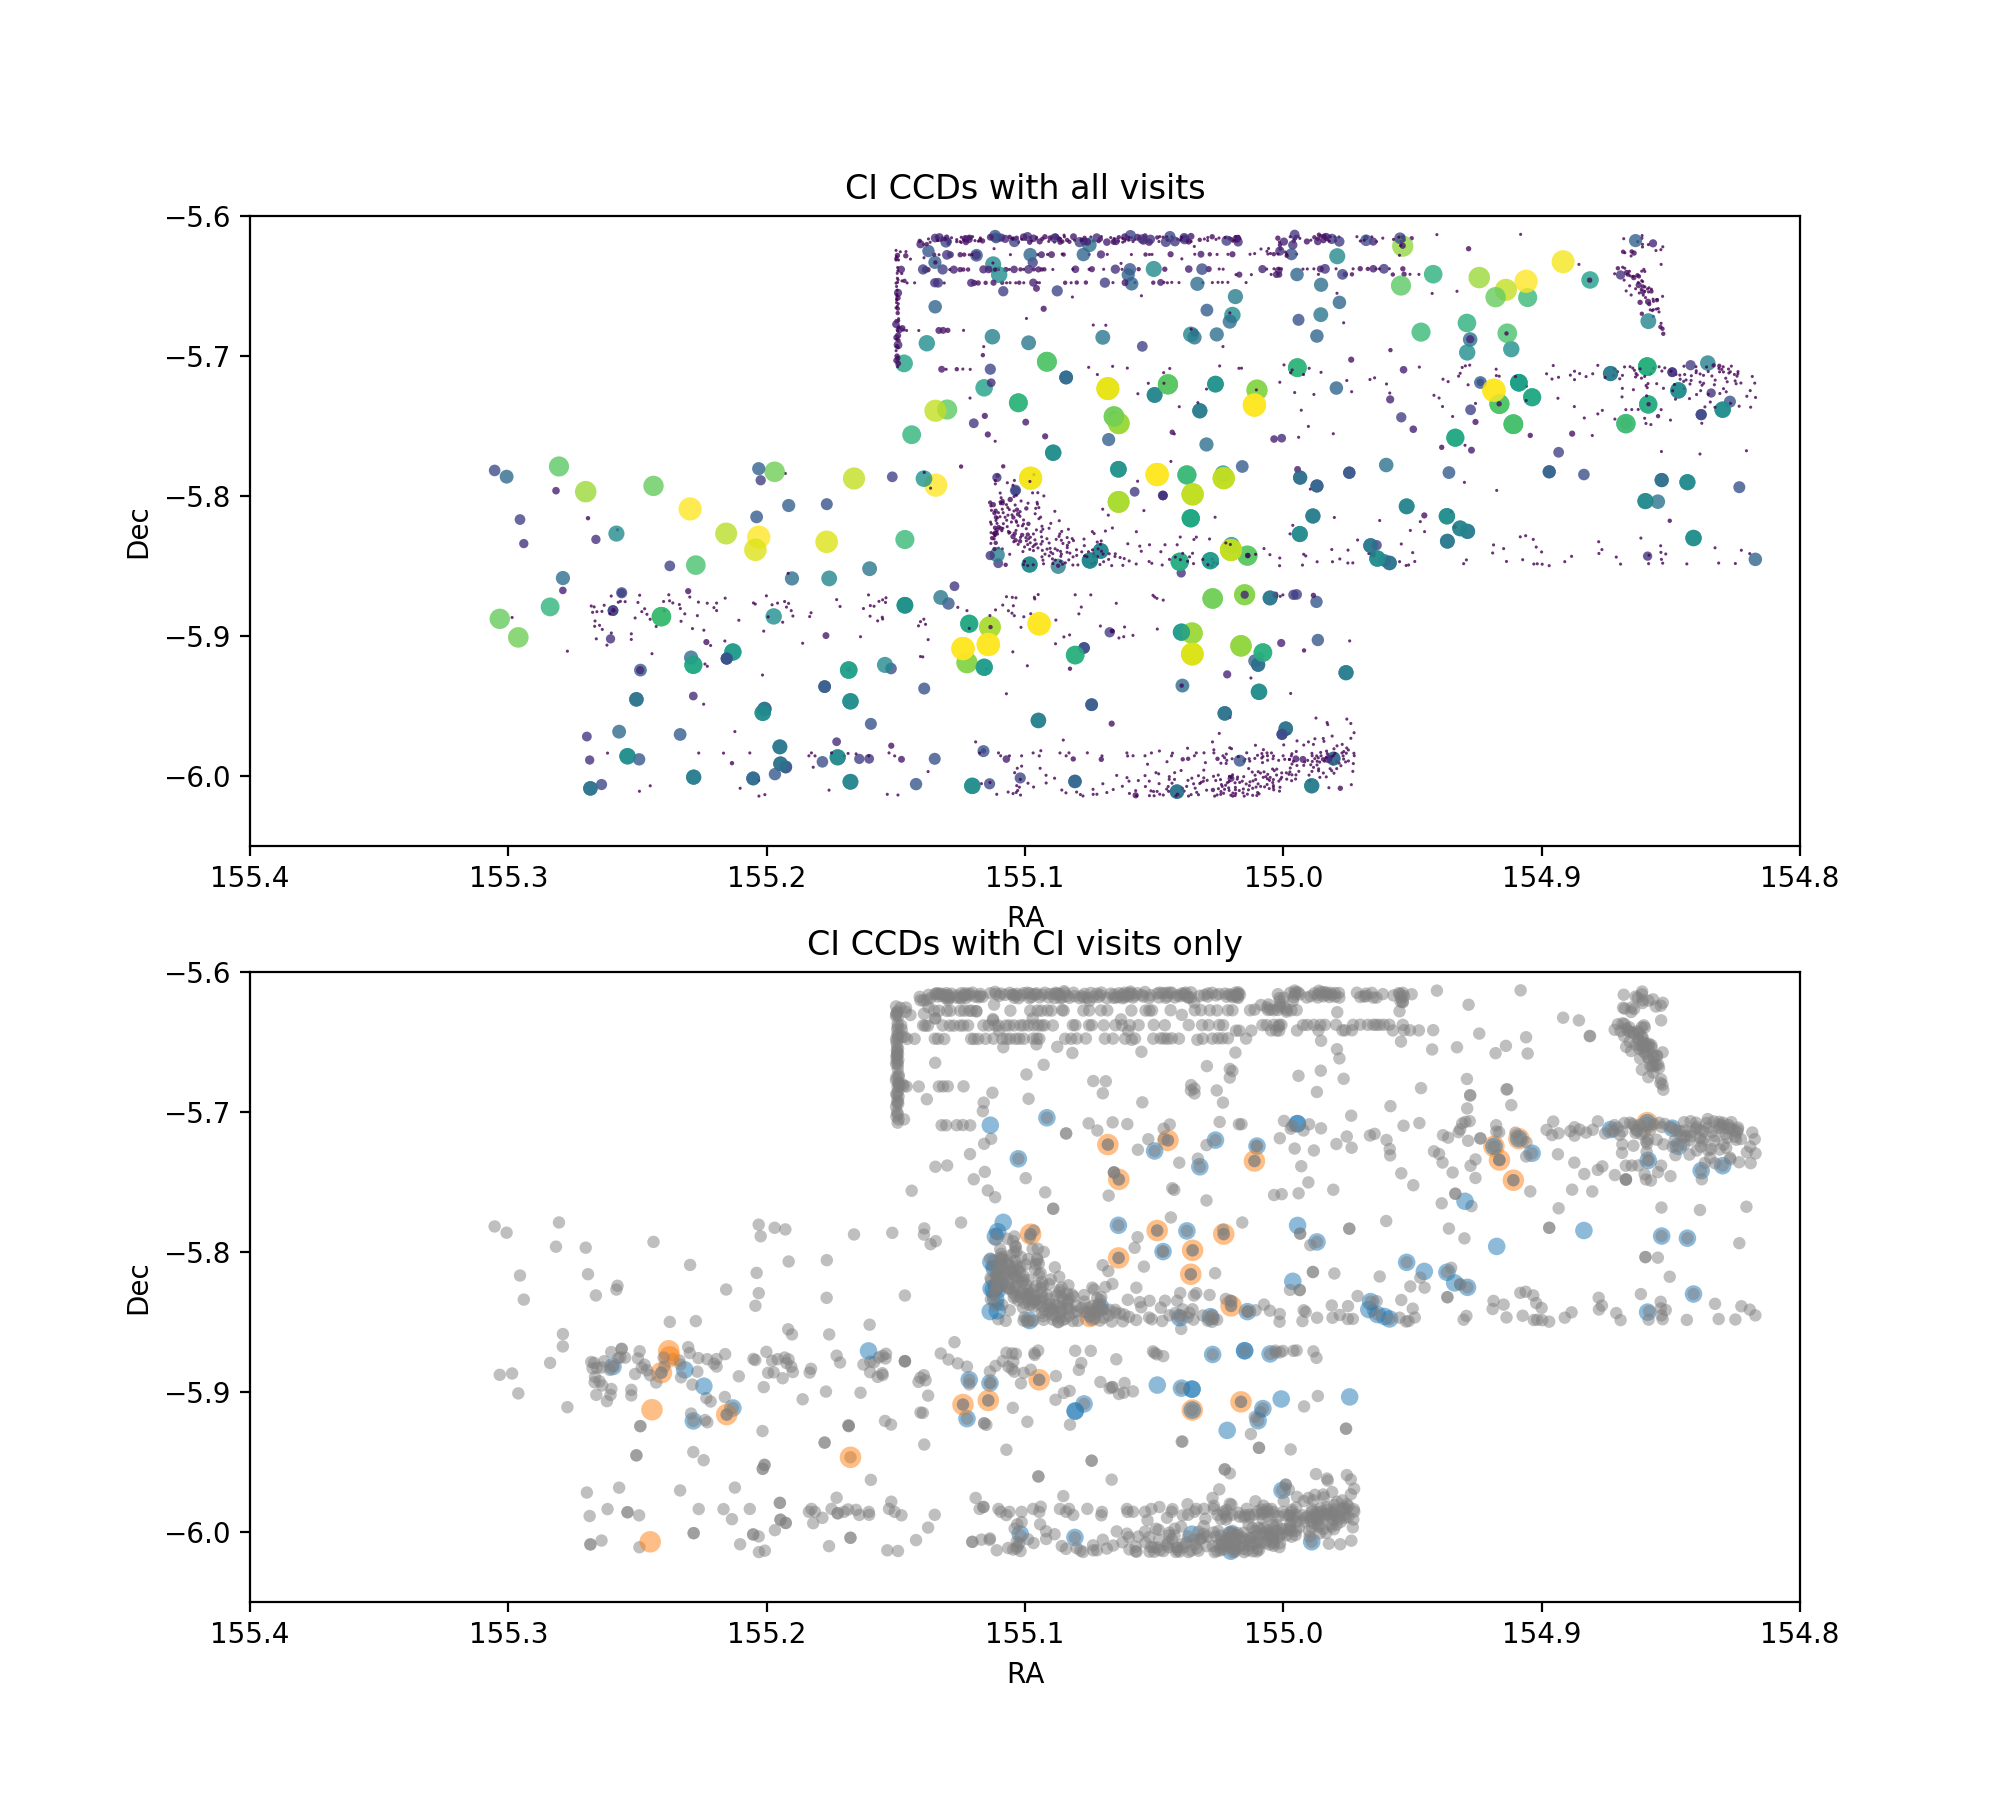

(-6.05, -5.6)

In [37]:
fig2 = plt.figure(facecolor='white', figsize=(10,9))
ax2 = fig2.add_subplot(211)

all_visits = ax2.scatter(objTable.loc[ci_objects, 'coord_ra'], objTable.loc[ci_objects, 'coord_dec'],
                         marker='.', lw=0, alpha=0.8, c=all_src_count, s=all_src_count*5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('CI CCDs with all visits')
plt.xlim([155.4, 154.8])
plt.ylim([-6.05, -5.6])

ax3 = fig2.add_subplot(212)
ci_visits = ax3.scatter(objTable.loc[ci_objects, 'coord_ra'].values, objTable.loc[ci_objects, 'coord_dec'].values,
                        marker='o', lw=0, alpha=0.5, s=[x*20 for x in ci_src_count], c=colors)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('CI CCDs with CI visits only')
plt.xlim([155.4, 154.8])
plt.ylim([-6.05, -5.6])

## Comparing a semi-random visit+ccd with the old ap_pipe run

In [38]:
dataId_compare = {'visit': 411758, 'ccdnum': 35, 'filter': 'g'}
compare_visits = [41175835, 41175828, 41175836, 41175829]

new_objects = []
for compare_visit in compare_visits:
    new_objects.extend(srcTable.loc[srcTable['ccdVisitId'] == compare_visit, 'diaObjectId'].values)
new_src_count = list(Counter(new_objects).values())

In [39]:
oldrepo = '/project/mrawls/hits2015/rerun/slurm6'
oldbutler = dafPersist.Butler(oldrepo)

In [40]:
sqliteFile = 'association.db'
connection = sqlite3.connect(os.path.join(oldrepo, sqliteFile))

tables = {'obj': 'dia_objects', 'src': 'dia_sources', 'ccd': 'CcdVisit'}

objTableOld = pd.read_sql_query('select * from {0};'.format(tables['obj']), connection)
srcTableOld = pd.read_sql_query('select * from {0};'.format(tables['src']), connection)
ccdTableOld = pd.read_sql_query('select * from {0};'.format(tables['ccd']), connection)

connection.close()

objTableOld.set_index('id', inplace=True)  # ONLY DO THIS ONCE
srcTableOld.set_index('id', inplace=True)  # ONLY DO THIS ONCE

In [41]:
old_objects = []
for compare_visit in compare_visits:
    old_objects.extend(srcTableOld.loc[srcTableOld['ccdVisitId'] == compare_visit, 'diaObjectId'].values)
old_src_count = list(Counter(old_objects).values())

<IPython.core.display.Javascript object>


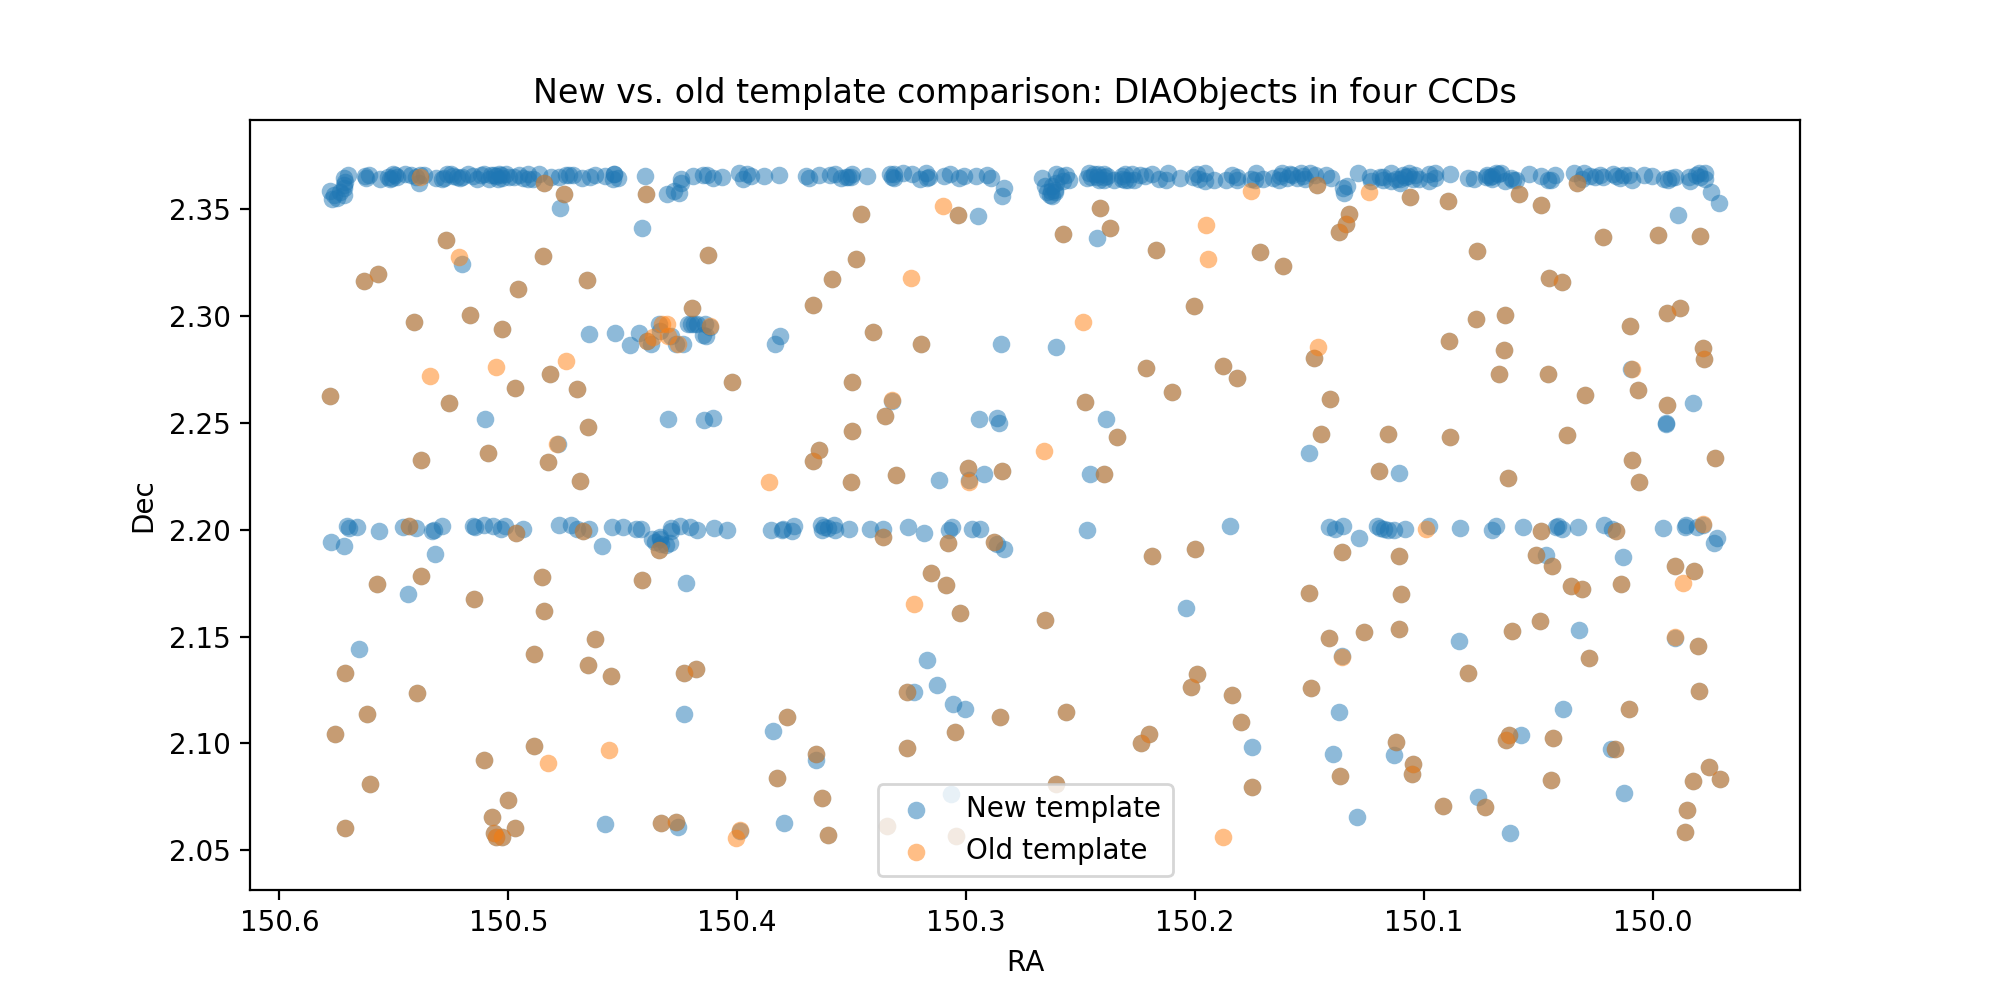

In [42]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)

new_visits = ax3.scatter(objTable.loc[new_objects, 'coord_ra'], objTable.loc[new_objects, 'coord_dec'],
                         marker='o', lw=0, alpha=0.5, s=40, color='C0', label='New template')

old_visits = ax3.scatter(objTableOld.loc[old_objects, 'coord_ra'], objTableOld.loc[old_objects, 'coord_dec'],
                         marker='o', lw=0, alpha=0.5, s=40, color='C1', label='Old template')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('New vs. old template comparison: DIAObjects in four CCDs')
plt.legend()
ax3.invert_xaxis()

## Define a "mini region" with a few thousand objects for future investigations

In [52]:
mini_region = ((objTable['coord_dec'] < -5.3) & (objTable['coord_dec'] > -5.9) & 
               (objTable['coord_ra'] > 155.0) & (objTable['coord_ra'] < 156.0) &
               (objTable['nDiaSources'] > 1))

mini_region_old = ((objTableOld['coord_dec'] < -5.3) & (objTableOld['coord_dec'] > -5.9) & 
                   (objTableOld['coord_ra'] > 155.0) & (objTableOld['coord_ra'] < 156.0) &
                   (objTableOld['nDiaSources'] > 1))

<IPython.core.display.Javascript object>


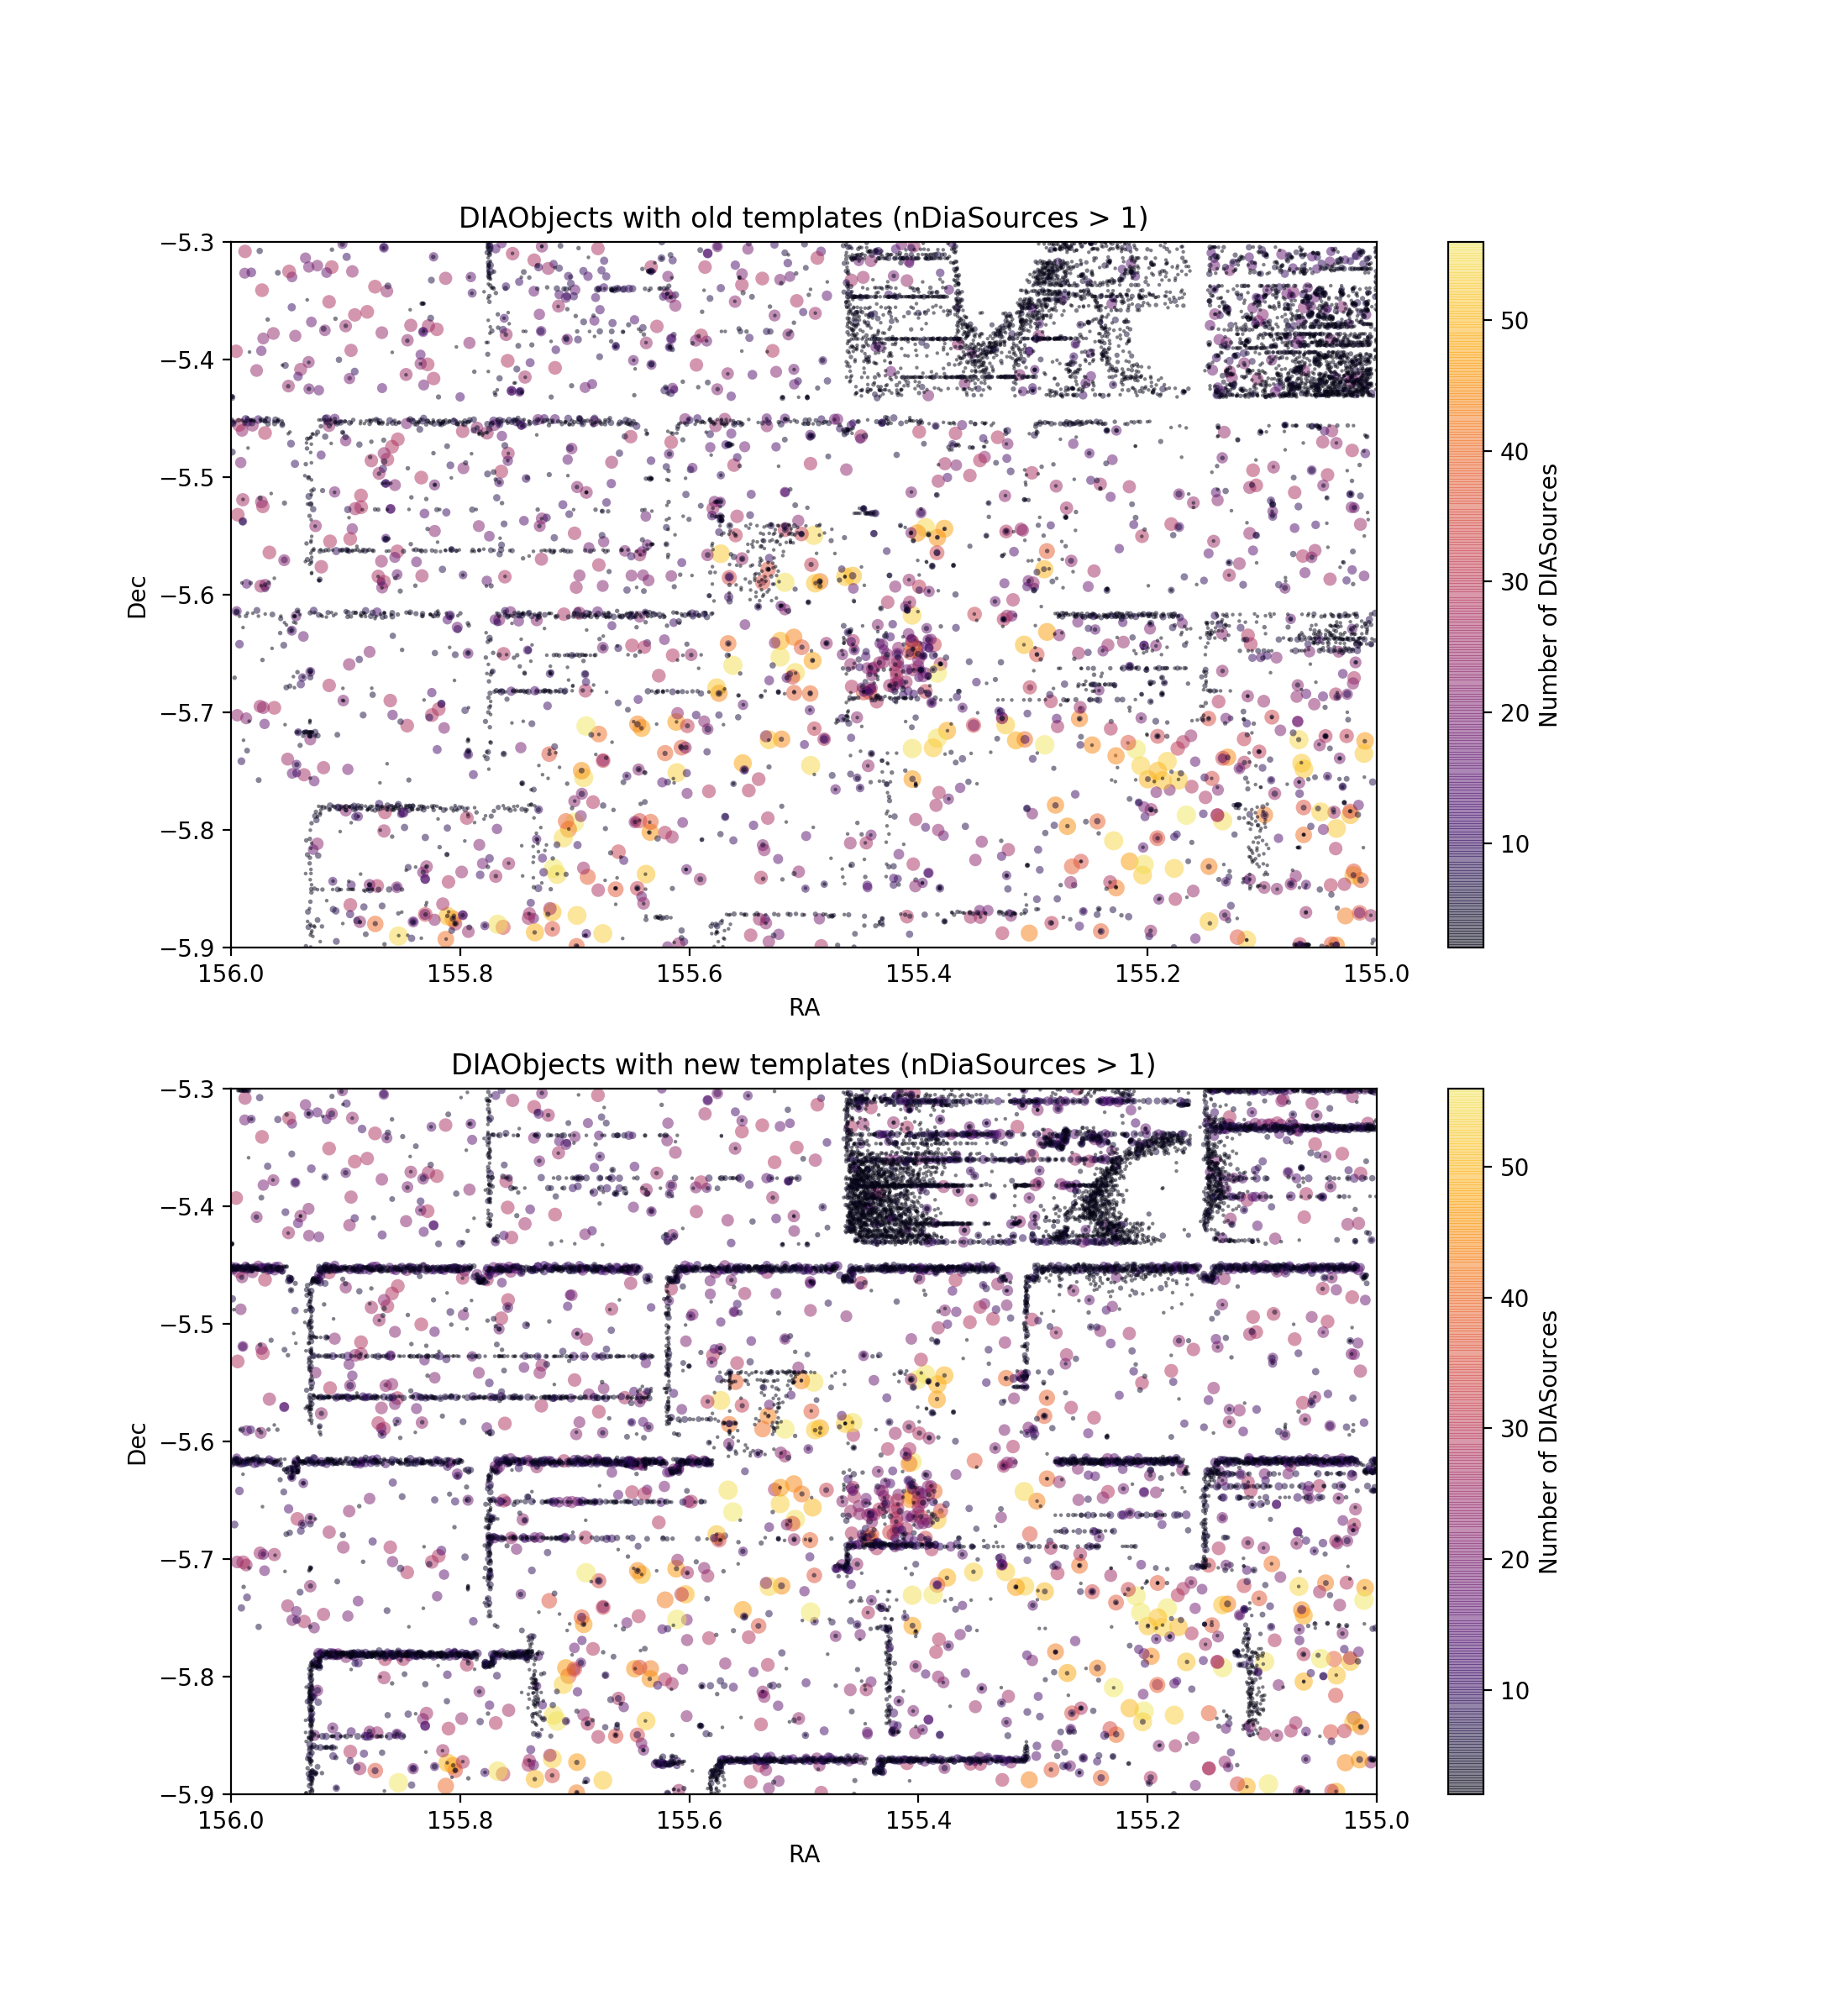

(-5.9, -5.3)

In [53]:
# Plot both old template run and new template run side by side

fig = plt.figure(facecolor='white', figsize=(11,12))

ax1 = fig.add_subplot(211)
cb1 = ax1.scatter(objTableOld.loc[mini_region_old, 'coord_ra'], objTableOld.loc[mini_region_old, 'coord_dec'], marker='.',
                  lw=0, s=objTableOld.loc[mini_region_old, 'nDiaSources']*5, c=objTableOld.loc[mini_region_old, 'nDiaSources'],
                  alpha=0.5, cmap=plt.cm.get_cmap('inferno'))
cbplot1 = plt.colorbar(cb1, ax=ax1)
cbplot1.set_label('Number of DIASources')
cbplot1.set_clim(0, 60)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('DIAObjects with old templates (nDiaSources > 1)')
plt.xlim([156, 155.0])
plt.ylim([-5.9, -5.3])


ax2 = fig.add_subplot(212)
cb2 = ax2.scatter(objTable.loc[mini_region, 'coord_ra'], objTable.loc[mini_region, 'coord_dec'], marker='.',
                  lw=0, s=objTable.loc[mini_region, 'nDiaSources']*5, c=objTable.loc[mini_region, 'nDiaSources'],
                  alpha=0.5, cmap=plt.cm.get_cmap('inferno'))
cbplot2 = plt.colorbar(cb2, ax=ax2)
cbplot2.set_label('Number of DIASources')
cbplot2.set_clim(0, 60)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('DIAObjects with new templates (nDiaSources > 1)')
plt.xlim([156, 155.0])
plt.ylim([-5.9, -5.3])

In [50]:
print(len(objTableOld.loc[mini_region_old, 'coord_ra']))
print(len(objTable.loc[mini_region, 'coord_ra']))

4076
7644


Running ap_pipe with the new templates (and any stack changes that have happened in the last few months) results in more edge source detections, but better handling of other problem areas (e.g., upper right corner of the above mini region plots). If we did not allow sources in regions that are flagged as edges, bad columns, etc., this would fix many of the problems. This "mini region" was selected to include some of Krzysztof's CI region, some of the two-HiTS-field overlap, some areas with bright sources and/or other artifacts causing template issues, and include a few thousand "real" time-variable objects.

Future work should include
* Decide how to handle sources which fall in flagged/masked regions on either template or science images
* See if DCR coadds as templates make an appreciable difference
* Try other flavors of coadd templates...
* Plot light curves for some objects that are most likely astrophysical
* Compare the objects we find with those in the HiTS data release